## Setting Up:

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.config_CH import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.geodata import *
from scripts.NN_networks import *
from scripts.geodata_plots import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.SwitzerlandConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/')

In [2]:
# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'

"""
# RGI Ids:
# Read rgi ids:
rgi_df = pd.read_csv(cfg.dataPath + path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
"""

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [3]:
seed_all(cfg.seed)

print("Using seed:", cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


Using seed: 20
CUDA is available


## Read GL data:

In [4]:
data_glamos = pd.read_csv('/home/mburlet/scratch/data/GLAMOS/point/csv/CH_wgms_dataset_all.csv')

# drop taelliboden if in there
if 'taelliboden' in data_glamos['GLACIER'].unique():
    data_glamos = data_glamos[data_glamos['GLACIER'] != 'taelliboden']

print('-------------------')
print('Number of glaciers:', len(data_glamos['GLACIER'].unique()))
print('Number of winter and annual samples:', len(data_glamos))
print('Number of annual samples:',
      len(data_glamos[data_glamos.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glamos[data_glamos.PERIOD == 'winter']))

-------------------
Number of glaciers: 38
Number of winter and annual samples: 33357
Number of annual samples: 7305
Number of winter samples: 26052


## Input data:
### Input dataset:

In [5]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': '/home/mburlet/scratch/data/DATA_MB/',
    'era5_climate_data':
    '/home/mburlet/scratch/data/ERA5Land/raw/era5_monthly_averaged_data.nc',
    'geopotential_data':
    '/home/mburlet/scratch/data/ERA5Land/raw/era5_geopotential_pressure.nc',
    'radiation_save_path': '/home/mburlet/scratch/data/GLAMOS/topo/pcsr/'
}
RUN = False
dataloader_gl = process_or_load_data(
    run_flag=RUN,
    data_glamos=data_glamos,
    paths=paths,
    cfg=cfg,
    vois_climate=vois_climate,
    vois_topographical=vois_topographical,
    output_file='CH_wgms_dataset_monthly_NN.csv')
data_monthly = dataloader_gl.data

data_monthly['GLWD_ID'] = data_monthly.apply(
    lambda x: mbm.data_processing.utils.get_hash(f"{x.GLACIER}_{x.YEAR}"),
    axis=1)
data_monthly['GLWD_ID'] = data_monthly['GLWD_ID'].astype(str)

dataloader_gl = mbm.dataloader.DataLoader(cfg,
                                          data=data_monthly,
                                          random_seed=cfg.seed,
                                          meta_data_columns=cfg.metaData)


2025-07-30 08:56:39,049 - INFO - Loaded preprocessed data.
2025-07-30 08:56:39,052 - INFO - Number of monthly rows: 284645
2025-07-30 08:56:39,097 - INFO - Number of annual rows: 86845
2025-07-30 08:56:39,137 - INFO - Number of winter rows: 197800


## Blocking on glaciers:

In [ ]:
test_glaciers = [
    'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
    'corvatsch', 'tsanfleuron', 'forno'
]

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of monthly test data:', len(data_test))

data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of monthly train data:', len(data_train))

if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('-------------\nTrain:')
print('Number of monthly winter and annual samples:', len(data_train))
print('Number of monthly annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of monthly winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']

print('Test:')
print('Number of monthly winter and annual samples:', len(data_test))
print('Number of monthly annual samples:', len(data_test_annual))
print('Number of monthly winter samples:', len(data_test_winter))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

# same for original data:
print('-------------\nIn annual format:')
print('Number of annual train rows:',
      len(data_glamos[data_glamos.GLACIER.isin(train_glaciers)]))
print('Number of annual test rows:',
      len(data_glamos[data_glamos.GLACIER.isin(test_glaciers)]))


Size of monthly test data: 0
Size of monthly train data: 284645
Percentage of test size: 0.00%
-------------
Train:
Number of monthly winter and annual samples: 284645
Number of monthly annual samples: 86845
Number of monthly winter samples: 197800
Test:
Number of monthly winter and annual samples: 0
Number of monthly annual samples: 0
Number of monthly winter samples: 0
Total:
Number of monthly rows: 284645
Number of annual rows: 86845
Number of winter rows: 197800
-------------
In annual format:
Number of annual train rows: 32574
Number of annual test rows: 0


In [7]:
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))

Test glaciers: (0) []
Percentage of test size: 0.00%
Size of test set: 0
Train glaciers: (31) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'clariden' 'corbassiere'
 'corvatsch' 'findelen' 'forno' 'gietro' 'gorner' 'gries' 'hohlaub'
 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar' 'otemma' 'pizol'
 'plainemorte' 'plattalva' 'rhone' 'sanktanna' 'schwarzbach' 'schwarzberg'
 'sexrouge' 'silvretta' 'tortin' 'tsanfleuron']
Size of train set: 284645


###### 80/20 val split

In [26]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

###### glacier based val split

Selected 8 glaciers for validation, covering 91708 rows (32.22% of data)


['gries',
 'corvatsch',
 'gorner',
 'pizol',
 'sexrouge',
 'clariden',
 'corbassiere',
 'silvretta']

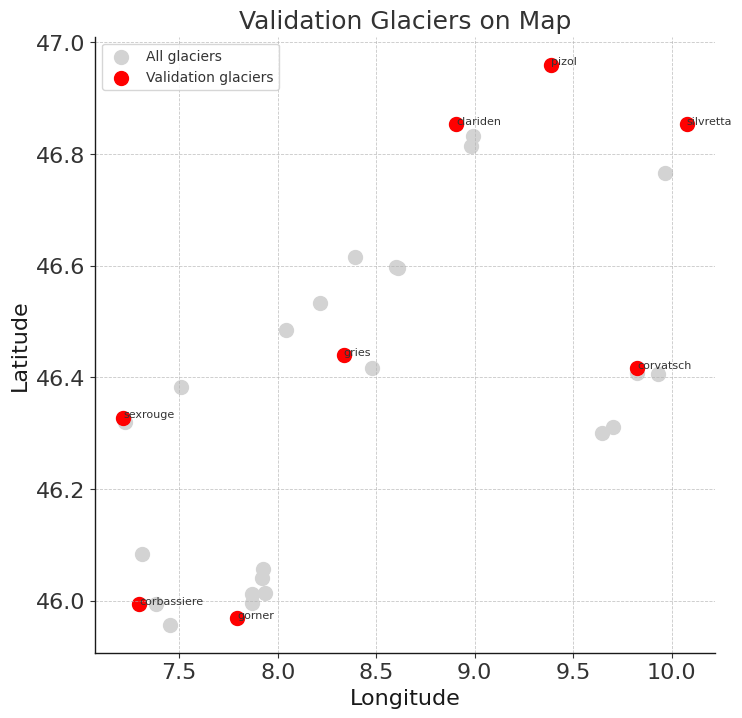

In [ ]:
# Selecting glaciers with kmeans clustering for validation set

from sklearn.cluster import KMeans


glacier_coords = train_set['df_X'].groupby('GLACIER')[['POINT_LON', 'POINT_LAT']].mean()
n_clusters = min(len(glacier_coords), 20)
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
labels = kmeans.fit_predict(glacier_coords)

glacier_sizes = train_set['df_X'].groupby('GLACIER').size()
clusters = {i: [] for i in range(n_clusters)}
for glacier, label in zip(glacier_coords.index, labels):
    clusters[label].append(glacier)

val_glaciers = []
rows_selected = 0
target_rows = int(0.2 * len(train_set['df_X']))

while rows_selected < target_rows:
    for i in range(n_clusters):
        glaciers = clusters[i]
        if glaciers:
            glacier = glaciers.pop(0)
            val_glaciers.append(glacier)
            rows_selected += glacier_sizes[glacier]
        if rows_selected >= target_rows:
            break

print(f"Selected {len(val_glaciers)} glaciers for validation, covering {rows_selected} rows ({rows_selected/len(train_set['df_X']):.2%} of data)")

display(val_glaciers)

val_coords = glacier_coords.loc[val_glaciers]

plt.figure(figsize=(8, 8))
plt.scatter(glacier_coords['POINT_LON'], glacier_coords['POINT_LAT'], c='lightgray', label='All glaciers')
plt.scatter(val_coords['POINT_LON'], val_coords['POINT_LAT'], c='red', label='Validation glaciers')
for name, row in val_coords.iterrows():
    plt.text(row['POINT_LON'], row['POINT_LAT'], name, fontsize=8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Validation Glaciers on Map')
plt.legend()
plt.show()

In [9]:
# Glacier-wise train/val split
data_train = train_set['df_X']
data_train['y'] = train_set['y']

val_glacier = ['gries',
 'albigna',
 'corbassiere',
 'sardona',
 'adler',
 'joeri',
 'sexrouge',
 'clariden',
 'aletsch']
train_glaciers = [g for g in train_glaciers if g not in val_glacier]

df_X_train = data_train[data_train['GLACIER'].isin(train_glaciers)].copy()
y_train = df_X_train['POINT_BALANCE'].values

df_X_val = data_train[data_train['GLACIER'].isin(val_glacier)].copy()
y_val = df_X_val['POINT_BALANCE'].values

print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

Train data glacier distribution: GLACIER
rhone          56073
silvretta      44477
findelen       33557
murtel         12481
basodino       10069
plainemorte     9960
allalin         7586
limmern         7484
pizol           6955
sanktanna       6731
tsanfleuron     6372
gietro          4149
otemma          3228
plattalva       2488
morteratsch     2461
schwarzbach     2373
schwarzberg     2364
corvatsch       1934
gorner          1810
hohlaub         1503
forno            471
tortin           387
oberaar          197
Name: count, dtype: int64
Val data glacier distribution: GLACIER
gries          25703
aletsch        16269
sexrouge        7542
adler           6188
corbassiere     2155
clariden        1132
joeri            354
albigna          192
Name: count, dtype: int64
Train data shape: (225110, 31)
Val data shape: (59535, 31)


## Neural Network:

In [27]:
def create_period_indicator(df):
    """Create numerical PERIOD_INDICATOR feature"""
    df = df.copy()
    df['PERIOD_INDICATOR'] = df['PERIOD'].map({'annual': 0, 'winter': 1})
    return df

# Apply to all datasets
df_X_train = create_period_indicator(df_X_train)
df_X_val = create_period_indicator(df_X_val)
test_set['df_X'] = create_period_indicator(test_set['df_X'])

print("PERIOD_INDICATOR created:")
print("Annual (0):", (df_X_train['PERIOD_INDICATOR'] == 0).sum())
print("Winter (1):", (df_X_train['PERIOD_INDICATOR'] == 1).sum())
print("Original PERIOD column preserved:", df_X_train['PERIOD'].unique())

PERIOD_INDICATOR created:
Annual (0): 62989
Winter (1): 141210
Original PERIOD column preserved: ['annual' 'winter']


In [ ]:
features_topo = [
    'ELEVATION_DIFFERENCE',
    'pcsr',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate) + ['PERIOD_INDICATOR']

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

# Because CH has some extra columns, we need to cut those
df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (204199, 31)
Shape of validation dataset: (51241, 31)
Shape of testing dataset: (29205, 31)
Running with features: ['ELEVATION_DIFFERENCE', 'pcsr', 'aspect_sgi', 'slope_sgi', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'PERIOD_INDICATOR']
Shape of training dataset only winter: (141210, 31)
Shape of validation dataset only winter: (35100, 31)


### Initialise network:

In [29]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter


def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)

In [30]:
"""
params = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
}

args = {
    'module': FlexibleNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__hidden_layers': params['module__hidden_layers'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 200,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'module__use_batchnorm': params['module__use_batchnorm'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
"""

custom_params = {
    'lr': 0.001,    # reduced from 0.001
    'batch_size': 128,  # Increased from 128
    'module__layer0': 128,
    'module__layer1': 96,
    'module__layer2': 64,
    'module__layer3': 32,
    'optimizer':torch.optim.Adam,
    'optimizer__weight_decay': 0,
}

params = custom_params

args = {
    'module': PeriodSpecificNetBigger,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__hidden_dim_0': params['module__layer0'],
    'module__hidden_dim_1': params['module__layer1'], 
    'module__hidden_dim_2': params['module__layer2'],
    'module__hidden_dim_3': params['module__layer3'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 300,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}


custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

### Create datasets:

In [31]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)

train: (23232,) (23232,)
validation: (5809,) (5809,)


### Train custom model:

Training the model...
Model parameters:
module: <class 'scripts.NN_networks.PeriodSpecificNetBigger'>
nbFeatures: 17
module__input_dim: 17
module__hidden_dim_0: 128
module__hidden_dim_1: 96
module__hidden_dim_2: 64
module__hidden_dim_3: 32
train_split: <function my_train_split at 0x783ccbfcbc40>
batch_size: 128
verbose: 1
iterator_train__shuffle: True
lr: 0.001
max_epochs: 300
optimizer: <class 'torch.optim.adam.Adam'>
optimizer__weight_decay: 0
callbacks: [('early_stop', <skorch.callbacks.training.EarlyStopping object at 0x783bd7102850>), ('lr_scheduler', <skorch.callbacks.lr_scheduler.LRScheduler object at 0x783bd412d7d0>)]
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1        1.2738        0.4525  0.0010  19.5685
      2        0.5095        0.4587  0.0010  18.3769
      3        0.4701        0.3000  0.0010  18.4684
      4        0.4225        0.3063  0.0010  18.2330
      5        0.3883        0.2516  0.0010  18.

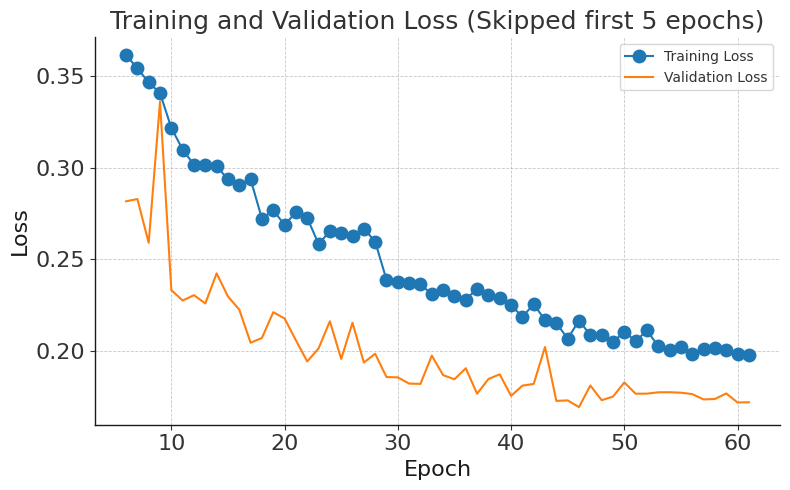

In [32]:
TRAIN = True
if TRAIN:
    custom_nn.seed_all()

    print("Training the model...")
    print('Model parameters:')
    for key, value in args.items():
        print(f"{key}: {value}")
    custom_nn.fit(dataset.X, dataset.y)
    # The dataset provided in fit is not used as the datasets are overwritten in the provided train_split function

    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"nn_model_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # After Training: Best weights are already loaded
    # Save the model
    custom_nn.save_model(model_filename)

    # save params dic
    params_filename = f"nn_params_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump(args, f)

### Load model and make predictions:

In [16]:
# Load model and set to CPU
model_filename = "nn_model_2025-07-10.pt"  # Replace with actual date if needed
# model_filename = "nn_model_finetuned_winter_2025-07-08.pt"
# read pickle with params
params_filename = "nn_params_2025-07-10.pkl"  # Replace with actual date if needed
with open(f"models/{params_filename}", "rb") as f:
    custom_params = pickle.load(f)

"""
params = custom_params

args = {
    'module': FlexibleNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__hidden_layers': params['module__hidden_layers'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 300,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'module__use_batchnorm': params['module__use_batchnorm'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
"""

loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
    cfg,
    model_filename,
    **{
        **args,
        **param_init
    },
)
loaded_model = loaded_model.set_params(device='cpu')
loaded_model = loaded_model.to('cpu')

In [17]:
params

{'lr': 0.001,
 'batch_size': 128,
 'module__layer0': 128,
 'module__layer1': 96,
 'module__layer2': 64,
 'module__layer3': 32,
 'optimizer': torch.optim.adam.Adam,
 'optimizer__weight_decay': 1e-05}

#### On test:

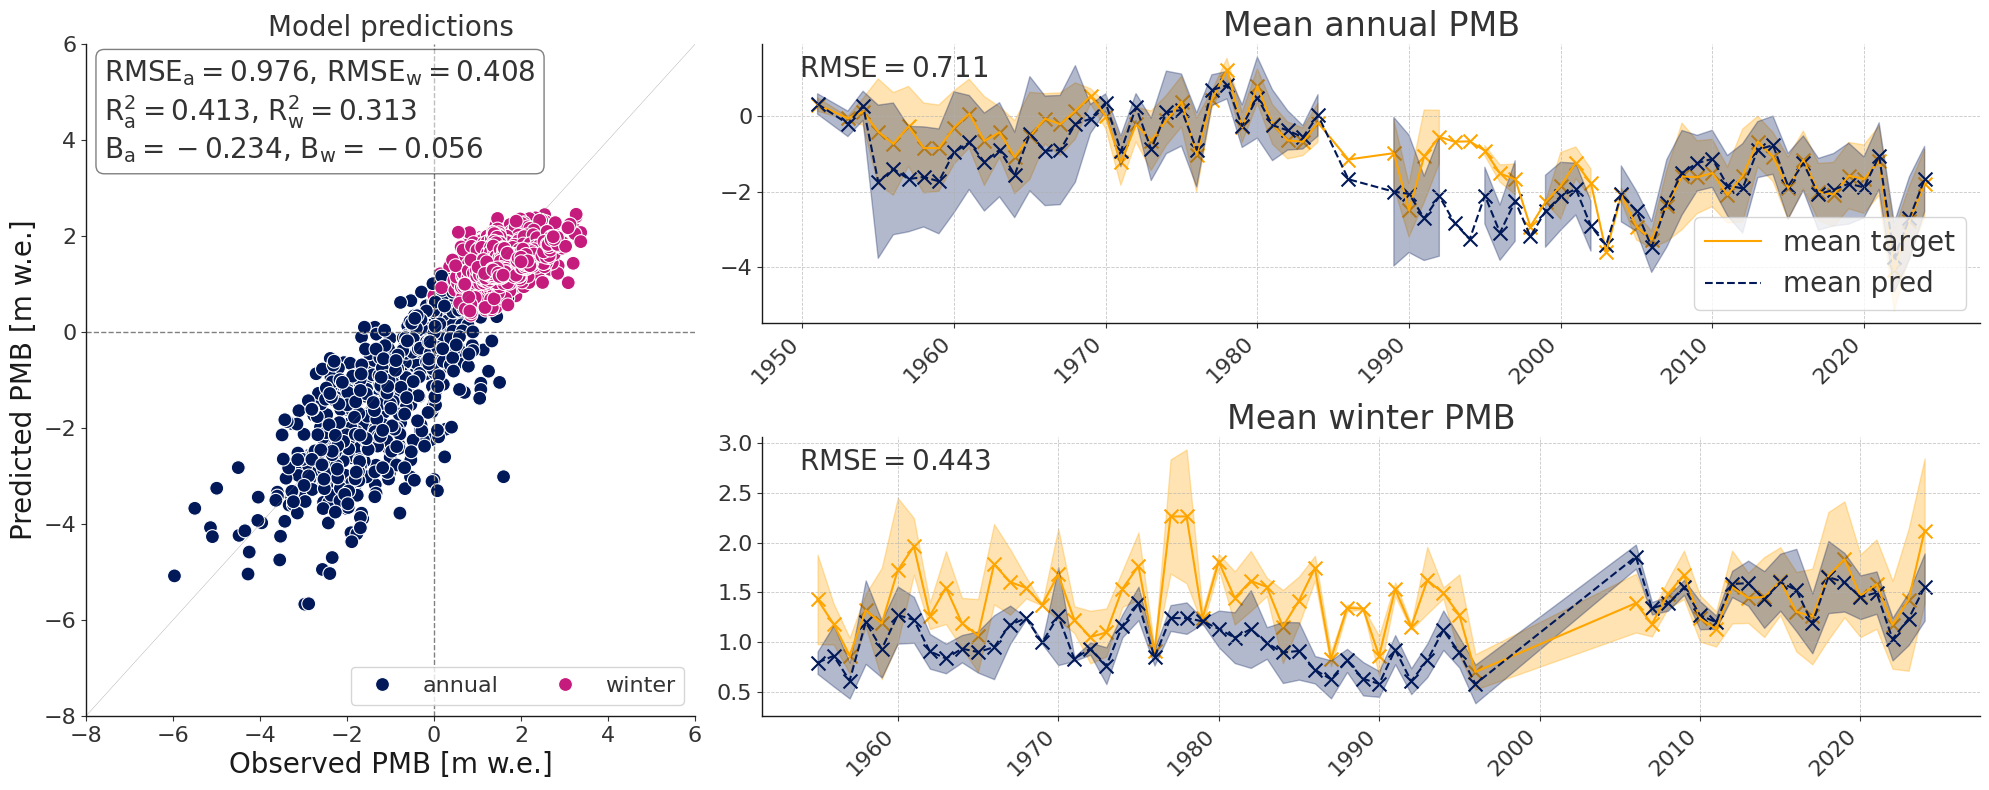

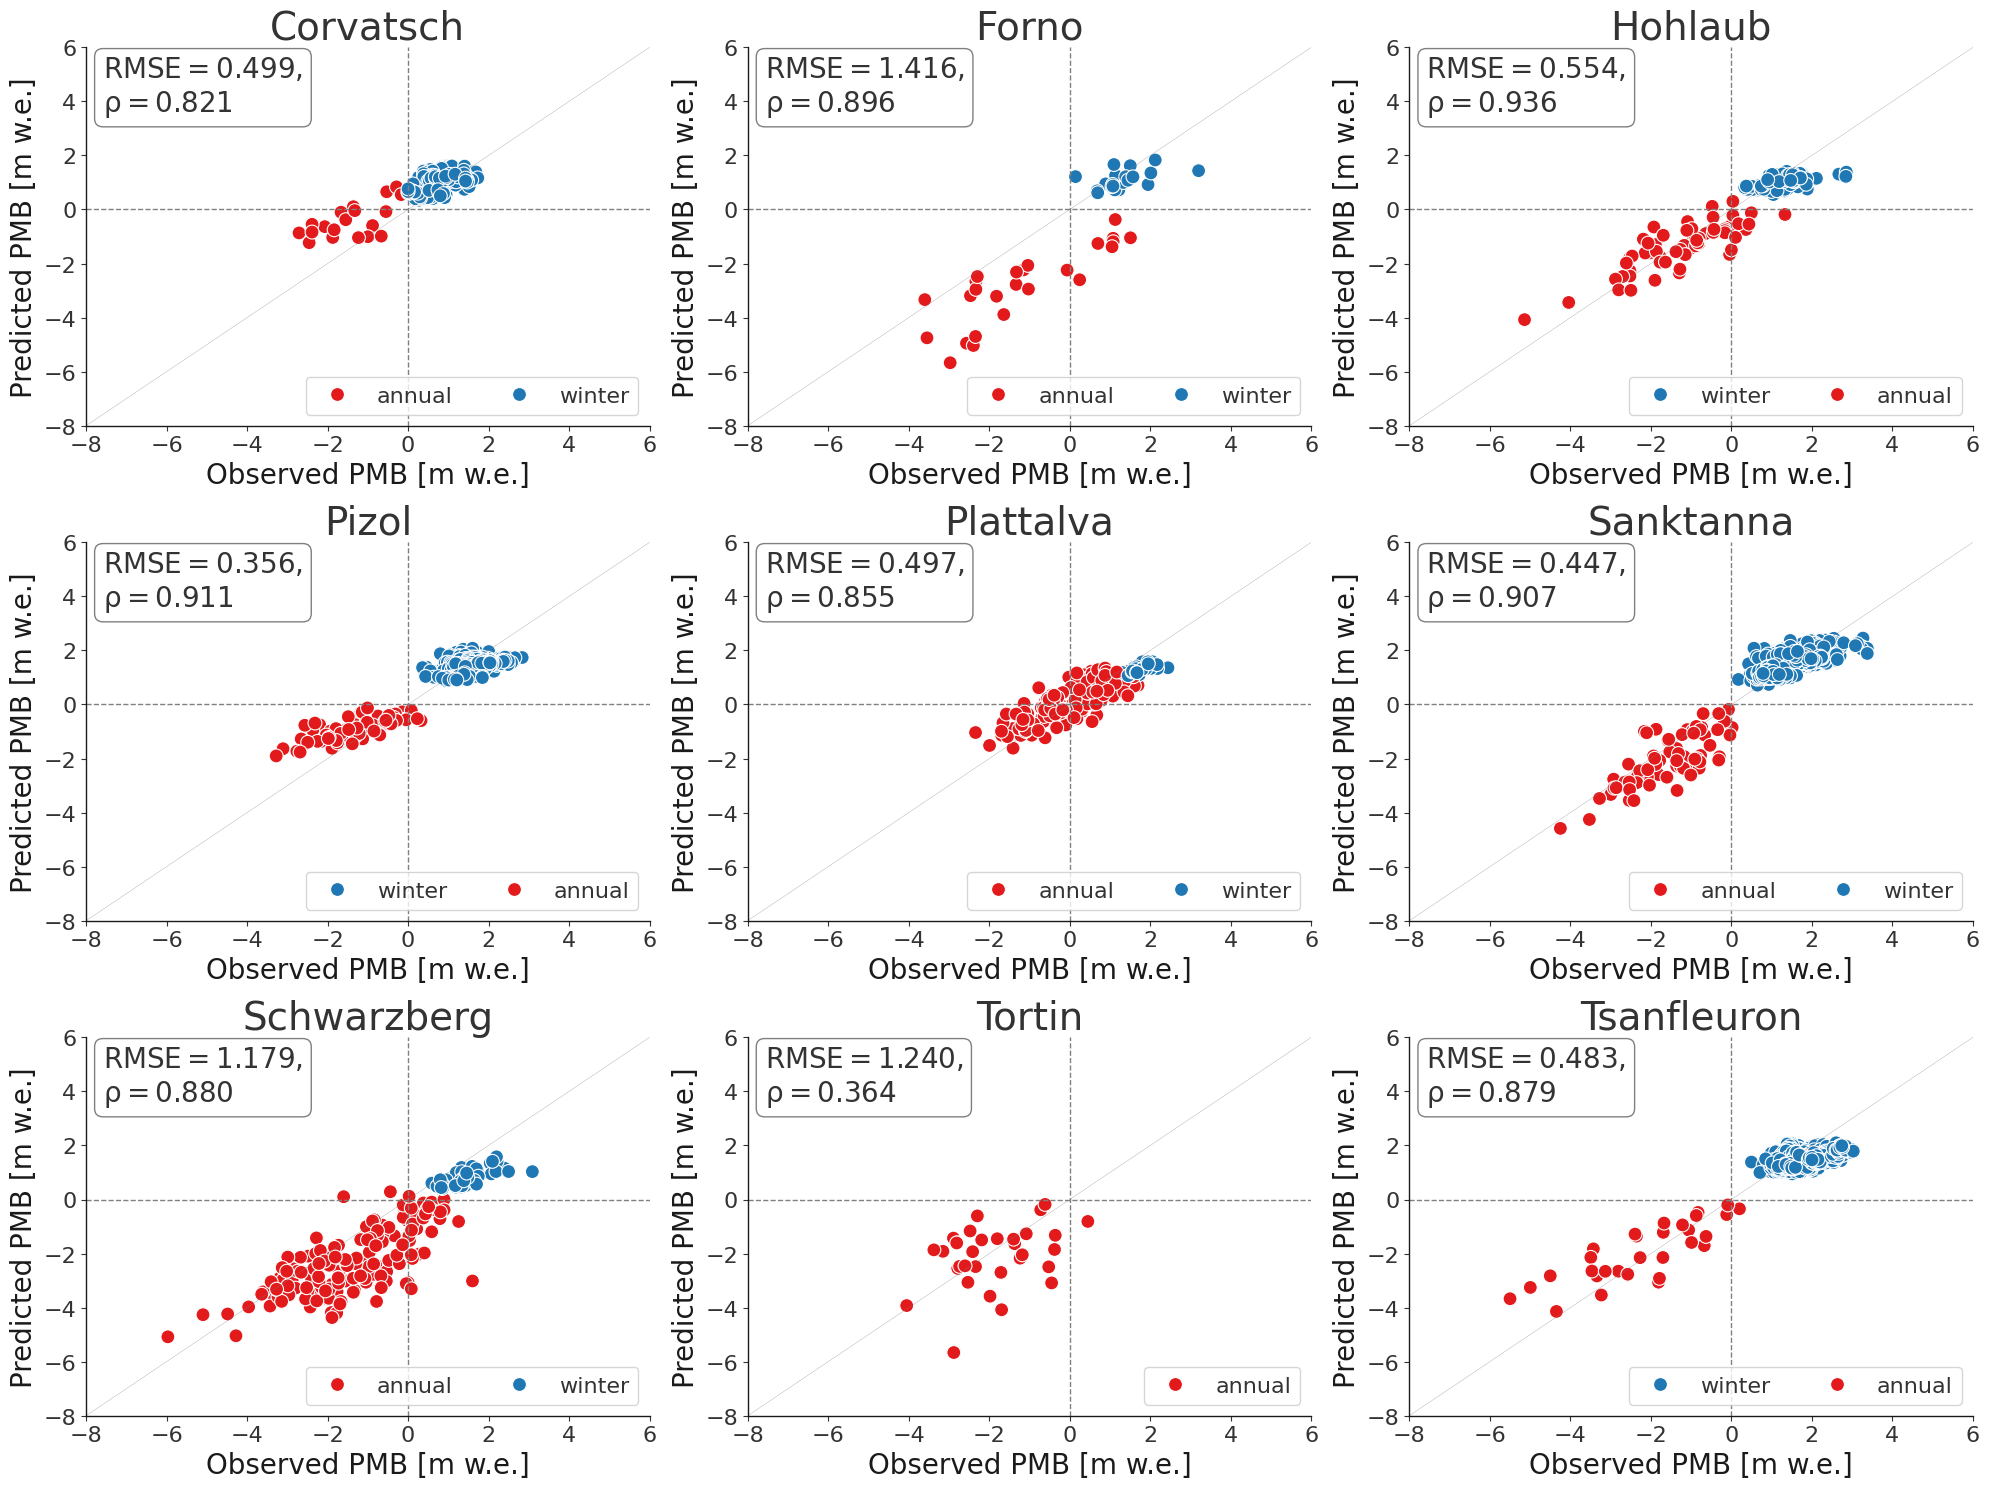

In [18]:
grouped_ids, scores_NN, ids_NN, y_pred_NN = evaluate_model_and_group_predictions(
    loaded_model, df_X_test_subset, test_set['y'], cfg, mbm)
scores_annual, scores_winter = compute_seasonal_scores(grouped_ids,
                                                       target_col='target',
                                                       pred_col='pred')
fig = plot_predictions_summary(grouped_ids=grouped_ids,
                               scores_annual=scores_annual,
                               scores_winter=scores_winter,
                               predVSTruth=predVSTruth,
                               plotMeanPred=plotMeanPred,
                               color_annual=color_dark_blue,
                               color_winter=color_pink,
                               ax_xlim=(-8, 6),
                               ax_ylim=(-8, 6))

PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))